In [1]:
"""
 Created by Myung-Joon Kwon
 mjkwon2021@gmail.com
 June 7, 2021

modify by YeongMin
"""

import sys, os
path = os.path.join(os.path.dirname(os.path.realpath(__name__)), '..')
if path not in sys.path:
    sys.path.insert(0, path)

import argparse
import pprint
import shutil

import logging
import time
import timeit
from pathlib import Path

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.nn import functional as F

from lib import models
from lib.config import config
from lib.config import update_config
from lib.core.criterion import CrossEntropy, OhemCrossEntropy
from lib.core.function import train, validate
from lib.utils.modelsummary import get_model_summary
from lib.utils.utils import create_logger, FullModel, get_rank
from lib.utils.utils import AverageMeter
from lib.utils.utils import get_confusion_matrix

from Splicing.data.data_core import SplicingDataset as splicing_dataset
from Splicing.data.Defacto import DefactoDataset

from pathlib import Path
from project_config import dataset_paths
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

def fix_seed(random_seed):
    """
    fix seed to control any randomness from a code 
    (enable stability of the experiments' results.)
    """
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
fix_seed(42)

In [2]:
def parse_args():
    parser = argparse.ArgumentParser(description='Train segmentation network')

    parser.add_argument('--cfg',
                        help='experiment configure file name',
                        required=True,
                        type=str)
    parser.add_argument('opts',
                        help="Modify config options using the command-line",
                        default=None,
                        nargs=argparse.REMAINDER)

    args = parser.parse_args()
    update_config(config, args)

    return args
DT = 2
DIR_IMGS = [r"F:\datasets\Defacto_splicing\splicing_3_img\img_jpg",
        r"F:\datasets\defacto_copy_move\copymove_img\img_jpg",
        r"F:\datasets\CASIA2.0\Tp_jpg"]
DIR_IMG = DIR_IMGS[DT]
DIR_MASKS = [r"F:\datasets\Defacto_splicing\splicing_3_annotations\probe_mask",
r"F:\datasets\defacto_copy_move\copymove_annotations\probe_mask",
r"F:\datasets\CASIA2.0\Groundtruth_jpg"]
DIR_MASK = DIR_MASKS[DT]
## CHOOSE ##
args = argparse.Namespace(cfg='../experiments/CAT_full.yaml', opts=['TEST.MODEL_FILE', '../output/splicing_dataset/CAT_full/best.pth.tar', 'TEST.FLIP_TEST', 'False', 'TEST.NUM_SAMPLES', '0'])
# args = argparse.Namespace(cfg='experiments/CAT_DCT_only.yaml', opts=['TEST.MODEL_FILE', 'output/splicing_dataset/CAT_DCT_only/DCT_only_v2.pth.tar', 'TEST.FLIP_TEST', 'False', 'TEST.NUM_SAMPLES', '0'])
update_config(config, args)

# cudnn related setting
cudnn.benchmark = config.CUDNN.BENCHMARK
cudnn.deterministic = config.CUDNN.DETERMINISTIC
cudnn.enabled = config.CUDNN.ENABLED

## CHOOSE ##
test_dataset = DefactoDataset(
            DIR_IMG,
            DIR_MASK,
            10000,
            512,
            'tra0in',None,
            blocks=('RGB', 'DCTvol', 'qtable'))
# splicing_dataset(crop_size=None, grid_crop=True, blocks=('RGB', 'DCTvol', 'qtable'), DCT_channels=1, mode='arbitrary', read_from_jpeg=True)  # full model
# test_dataset = splicing_dataset(crop_size=None, grid_crop=True, blocks=('DCTvol', 'qtable'), DCT_channels=1, mode='arbitrary', read_from_jpeg=True)  # DCT stream

# print(test_dataset.get_info())

testloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,  # must be 1 to handle arbitrary input sizes
    shuffle=False,  # must be False to get accurate filename
    num_workers=1,
    pin_memory=False)
model = eval('models.' + config.MODEL.NAME +
                '.get_seg_model')(config)
if config.TEST.MODEL_FILE:
    model_state_file = config.TEST.MODEL_FILE
else:
    raise ValueError("Model file is not specified.")
print('=> loading model from {}'.format(model_state_file))
criterion = CrossEntropy(ignore_label=config.TRAIN.IGNORE_LABEL).cuda()
model = FullModel(model, criterion)
checkpoint = torch.load(model_state_file)
model.model.load_state_dict(checkpoint['state_dict'])
print("Epoch: {}".format(checkpoint['epoch']))
gpus = list(config.GPUS)
model = nn.DataParallel(model, device_ids=gpus).cuda()

=> loading model from ../output/splicing_dataset/CAT_full/best.pth.tar
Epoch: 13


In [6]:
def dice_coeff_loss(pred, target):
    smooth = 1e-7
    h,w=512,512
    img = target.cpu().numpy()
    for i in range(len(img)-1,0,-1):
        if img[0,i]!=-1.:
            w = i  
            break
    for i in range(len(img)-1,0,-1):
        if img[i,0]!=-1.:
            h = i  
            break
    pred = (pred[:h,:w] >0.5).float()
    target = (target[:h,:w] > 0.5).float()
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()

    return (2. * intersection) / (m1.sum() + m2.sum() + smooth)

def main(idx,dt):
    # args = parse_args()
    # Instead of using argparse, force these args:
    DT = dt
    DIR_IMGS = [r"F:\datasets\Defacto_splicing\splicing_3_img\img_jpg",
            r"F:\datasets\defacto_copy_move\copymove_img\img_jpg",
            r"F:\datasets\CASIA2.0\Tp_jpg"]
    DIR_IMG = DIR_IMGS[DT]
    DIR_MASKS = [r"F:\datasets\Defacto_splicing\splicing_3_annotations\probe_mask",
    r"F:\datasets\defacto_copy_move\copymove_annotations\probe_mask",
    r"F:\datasets\CASIA2.0\Groundtruth_jpg"]
    DIR_MASK = DIR_MASKS[DT]
    ## CHOOSE ##
    args = argparse.Namespace(cfg='../experiments/CAT_full.yaml', opts=['TEST.MODEL_FILE', '../output/splicing_dataset/CAT_full/best.pth.tar', 'TEST.FLIP_TEST', 'False', 'TEST.NUM_SAMPLES', '0'])
    # args = argparse.Namespace(cfg='experiments/CAT_DCT_only.yaml', opts=['TEST.MODEL_FILE', 'output/splicing_dataset/CAT_DCT_only/DCT_only_v2.pth.tar', 'TEST.FLIP_TEST', 'False', 'TEST.NUM_SAMPLES', '0'])
    update_config(config, args)

    # cudnn related setting
    cudnn.benchmark = config.CUDNN.BENCHMARK
    cudnn.deterministic = config.CUDNN.DETERMINISTIC
    cudnn.enabled = config.CUDNN.ENABLED

    ## CHOOSE ##
    test_dataset = DefactoDataset(
                DIR_IMG,
                DIR_MASK,
                10000,
                512,
                'tra0in',None,
                blocks=('RGB', 'DCTvol', 'qtable'))
    # splicing_dataset(crop_size=None, grid_crop=True, blocks=('RGB', 'DCTvol', 'qtable'), DCT_channels=1, mode='arbitrary', read_from_jpeg=True)  # full model
    # test_dataset = splicing_dataset(crop_size=None, grid_crop=True, blocks=('DCTvol', 'qtable'), DCT_channels=1, mode='arbitrary', read_from_jpeg=True)  # DCT stream

    # print(test_dataset.get_info())

    testloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,  # must be 1 to handle arbitrary input sizes
        shuffle=False,  # must be False to get accurate filename
        num_workers=1,
        pin_memory=False)

    # criterion
    if config.LOSS.USE_OHEM:
        criterion = OhemCrossEntropy(ignore_label=config.TRAIN.IGNORE_LABEL,
                                     thres=config.LOSS.OHEMTHRES,
                                     min_kept=config.LOSS.OHEMKEEP,
                                     weight=test_dataset.class_weights).cuda()
    else:
        criterion = CrossEntropy(ignore_label=config.TRAIN.IGNORE_LABEL).cuda()

    model = eval('models.' + config.MODEL.NAME +
                 '.get_seg_model')(config)
    if config.TEST.MODEL_FILE:
        model_state_file = config.TEST.MODEL_FILE
    else:
        raise ValueError("Model file is not specified.")
    print('=> loading model from {}'.format(model_state_file))
    model = FullModel(model, criterion)
    checkpoint = torch.load(model_state_file)
    model.model.load_state_dict(checkpoint['state_dict'])
    print("Epoch: {}".format(checkpoint['epoch']))
    gpus = list(config.GPUS)
    model = nn.DataParallel(model, device_ids=gpus).cuda()

    dataset_paths['SAVE_PRED'].mkdir(parents=True, exist_ok=True)

    with torch.no_grad():
        # for index, (image, label, qtable) in enumerate(tqdm(testloader)):
            image, label, qtable = test_dataset.__getitem__(idx)       
            size = label.size()
            image = image.cuda()
            label = label.long().cuda()
            model.eval()
            
            _, pred = model(image.unsqueeze(0), label.unsqueeze(0), qtable.unsqueeze(0))
            pred = F.upsample(input=pred, size=(
                        size[-2], size[-1]), mode='bilinear')
            pred = torch.squeeze(pred, 0)
            pred = F.softmax(pred, dim=0)[1]
            # pred = pred.cpu().numpy()

            # filename
            # filename = os.path.splitext(get_next_filename(index))[0] + ".png"
            dice_coef = dice_coeff_loss(pred.float(),label.float()) 
            print("dice coff : ",dice_coef)
            pred_ = pred
            pred_ = pred_.to('cpu').detach().numpy()

            h,w=512,512
            img = image[:3].permute(1,2,0).cpu().numpy()
            img = (img*127.5+127.5)/255.0
            for i in range(len(img)-1,0,-1):
                if img[0,i,0]!=127.5/255.:
                    w = i  
                    break
            for i in range(len(img)-1,0,-1):
                if img[i,0,0]!=127.5/255.:
                    h = i  
                    break
                
            img = img[:h,:w,:]
            pred_ = pred_[:h,:w]
            mask = label[:h,:w].cpu().numpy()
            mask = mask >0.5
            mask = mask / 255.
            plt.figure(figsize=(10,2))
            plt.subplot(141)
            plt.imshow(img)
            plt.title('Input')
            plt.axis('off')

            plt.subplot(142)
            plt.imshow(mask)
            plt.title('Ground Truth')
            plt.axis('off')

            plt.subplot(143)
            plt.imshow(pred_>0.5)#,cmap='jet',interpolation='nearest')
            plt.title('Predict')
            plt.axis('off')

            plt.subplot(144)
            plt.imshow(img)
            plt.imshow(pred_ ,alpha=0.6,cmap='jet')
            plt.title('Heatmap')
            plt.axis('off')
            plt.show()
            return image[:3]

=> loading model from ../output/splicing_dataset/CAT_full/best.pth.tar
Epoch: 13


c:\Users\zxcas\anaconda3\envs\style\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
c:\Users\zxcas\anaconda3\envs\style\lib\site-packages\torch\nn\functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


dice coff :  tensor(0.8893, device='cuda:0')


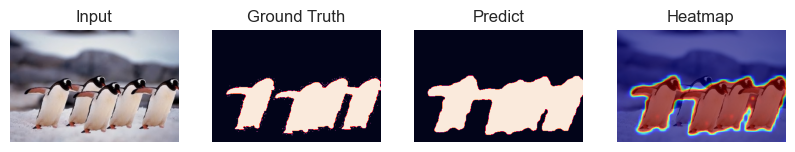

In [11]:
# dt : 0 sp. 1 cm, 2 ca
a = main(1394,2)

In [126]:
def plot_fig(models,names,dt,save,*index,**kwargs):
    """
    args:

    """
    def save_np():
        save_path = r"./log/figure"
        dt_path = os.path.join(save_path,"np",dt_dict[dt])
        os.makedirs(dt_path,exist_ok=True)
        file_name = f"{dt_dict[dt]}_{kwargs['axis']}_{idx}.npy"
        np.save(os.path.join(dt_path,file_name),preds[0])
    def load_np():
        save_path = r"./log/figure"
        dt_path = os.path.join(save_path,"np",dt_dict[dt])
        os.makedirs(dt_path,exist_ok=True)
        file_name = f"{dt_dict[dt]}_{kwargs['axis']}_{idx}.npy"
        ld = np.load(os.path.join(dt_path,file_name))

    def axis_0():
            rows = len(preds) + 2
            font_size = 18
            fig = plt.figure(figsize=(30.,20.),dpi=96)

            save_np()
            # load_np()
            
            ax1 = fig.add_subplot(rows,1,1)
            ax1.imshow(img)
            ax1.set_title('Input',fontsize=font_size)
            ax1.axis('off')

            ax2 = fig.add_subplot(rows,1,2)
            ax2.imshow(mask,cmap='gray')
            ax2.set_title('Ground Truth',fontsize=font_size)
            ax2.axis('off')

            for i in range(3,len(preds)+3):
                ax = fig.add_subplot(rows,1,i)
                ax.imshow(imgs[i-3])
                ax.imshow(preds[i-3] ,alpha=0.6,cmap='jet')
                ax.set_title(f'{names[i-3]}',fontsize=font_size)
                ax.axis('off')

            return fig
    
    def axis_1():
        cols = len(preds) + 2
        fig = plt.figure(figsize=(30.,20.),dpi=96)
        font_size = 25
        
        ##
        save_np()
        load_np()
        ##
        ax1 = fig.add_subplot(1,cols,1)
        ax1.imshow(img)
        ax1.set_title('Input',fontsize=font_size)
        ax1.axis('off')
        ax2 = fig.add_subplot(1,cols,2)
        ax2.imshow(mask,cmap='gray')
        ax2.set_title('Ground Truth',fontsize=font_size)
        ax2.axis('off')

        for i in range(3,len(preds)+3):
            ax = fig.add_subplot(1,cols,i)
            ax.imshow(imgs[i-3])
            ax.imshow(preds[i-3] ,alpha=0.6,cmap='jet')
            ax.set_title(f'{names[i-3]}',fontsize=font_size)
            ax.axis('off')
        fig.tight_layout()
        
        return fig
  
    dt_dict = {0:"DEFACTO_SP",
               1:"DEFACTO_CM",
               2:"CASIAv2_SP_CM"}
    figs =[]
    test_dataset = DefactoDataset(
                DIR_IMGS[dt],
                DIR_MASKS[dt],
                12000,
                512,
                'tra0in',None,
                blocks=('RGB', 'DCTvol', 'qtable'))
    print(DIR_IMGS[dt])
    total = np.zeros((1,5))
    for n,idx in enumerate(index):
        preds =[]
        imgs=[]
        masks=[]
        dices=[]
        device = torch.device("cuda:0")
        for model,name in zip(models,names):
            
            with torch.no_grad():
            # for index, (image, label, qtable) in enumerate(tqdm(testloader)):
                image, label, qtable = test_dataset.__getitem__(idx)       
                size = label.size()
                image = image.cuda()
                label = label.long().cuda()
                model.eval()
                
                _, pred = model(image.unsqueeze(0), label.unsqueeze(0), qtable.unsqueeze(0))
                pred = F.upsample(input=pred, size=(
                            size[-2], size[-1]), mode='bilinear')

                cm = get_confusion_matrix(
                label.unsqueeze(0),
                pred,
                size,
                2,
                -1)
                TN = cm[0, 0]
                FN = cm[1, 0]
                FP = cm[0, 1]
                TP = cm[1, 1]
                dice = (2*TP)/(2*TP+FN+FP+1e-7)
                # print("cm: ",current_confusion_matrix)
                pred = torch.squeeze(pred, 0)
                pred = F.softmax(pred, dim=0)[1]
                dice_coef = dice_coeff_loss(pred.float(),label.float()) 
                # print("dice coff(sum) : ",dice_coef)
                pred_ = pred
                pred_ = pred_.to('cpu').detach().numpy()
                
                h,w=512,512
                img = image[:3].permute(1,2,0).cpu().numpy()
                img = (img*127.5+127.5)/255.0
                for i in range(len(img)-1,0,-1):
                    if img[0,i,0]!=127.5/255.:
                        w = i  
                        break
                for i in range(len(img)-1,0,-1):
                    if img[i,0,0]!=127.5/255.:
                        h = i  
                        break
                    
                img = img[:h,:w,:]
                pred_ = pred_[:h,:w]
                mask = label[:h,:w].cpu().numpy()
                pred_[-1,-1] = 0.99
            preds.append(pred_)
            imgs.append(img)
            masks.append(mask)
            dices.append(dice)
        print(np.shape(total),np.shape(np.array(dices)))
        total = np.vstack((total,np.array(dices)))
        
        
        if 'axis' in kwargs.keys():
            if kwargs['axis']:
                fig = axis_1()
            else:
                fig = axis_0()
        else:
            fig = axis_0()
        
        if save:
            save_path = r"./log/figure"
            dt_path = dt_dict[dt]
            os.makedirs(os.path.join(save_path,dt_path),exist_ok=True)
            m = '_'.join(names)
            file_name = f"{dt_dict[dt]}_{idx}_{m}.png"
            fig.tight_layout()
            fig.savefig(os.path.join(save_path,dt_path,file_name),format='png',bbox_inches='tight')
        figs.append(fig)

    print(np.sum(total,axis=0)/len(index))
    return figs

models = [model,]
names = ['CAT-Net',]

In [124]:
def f1(cm_):
        cm =np.array(
                [[5.9674e+04, 2.2220e+03],
        [6.0000e+00, 3.6402e+04]]
                )
        cm = cm_
        TN = cm[0, 0]
        FN = cm[1, 0]
        FP = cm[0, 1]
        TP = cm[1, 1]

        dice = (2*TP)/(2*TP+FN+FP)
        recall =TP/(TP+FN)
        pre = TP/(TP+FP)
        # print('recall, precision : ',recall,pre)
        acc = (TP+TN)/(TP+TN+FP+FN)
        print(dice.astype(np.float16), acc.astype(np.float16), 2*(recall*pre)/(recall+pre))
        return dice
a= f1(
        np.array(
                [[5.9674e+04, 2.2220e+03],
        [6.0000e+00, 3.6402e+04]]
                )
)

0.97 0.9775 0.9703060027721506


[3044, 2724, 713, 82, 1168]
F:\datasets\CASIA2.0\Tp_jpg
(1, 5) (5,)
[0.90424936 0.90424936 0.90424936 0.90424936 0.90424936]


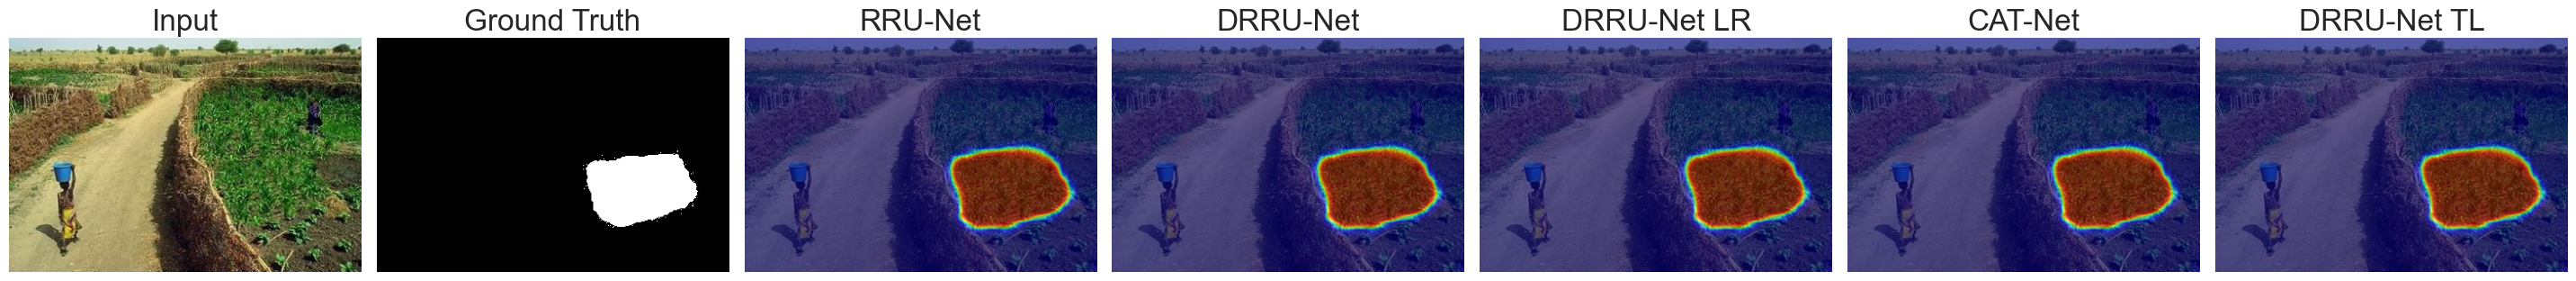

In [133]:
nums = np.random.randint(3059,size=5)
print(list(nums))
nums = [977]#[3001 ,7241]#[499, 753, 1243, 1856] #[10,19,48,997]#[ 753,1243,]
models = [model,model,model,model,model]
names = ['RRU-Net','DRRU-Net','DRRU-Net LR','CAT-Net','DRRU-Net TL']

a = plot_fig(models,names,2,True,*nums,axis=1)


[1140, 133, 2105, 684, 2719]
F:\datasets\CASIA2.0\Tp_jpg


c:\Users\zxcas\anaconda3\envs\style\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
c:\Users\zxcas\anaconda3\envs\style\lib\site-packages\torch\nn\functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


(1, 5) (5,)
(383, 255, 3)
(2, 5) (5,)
(255, 383, 3)
[0.84231227 0.84231227 0.84231227 0.84231227 0.84231227]


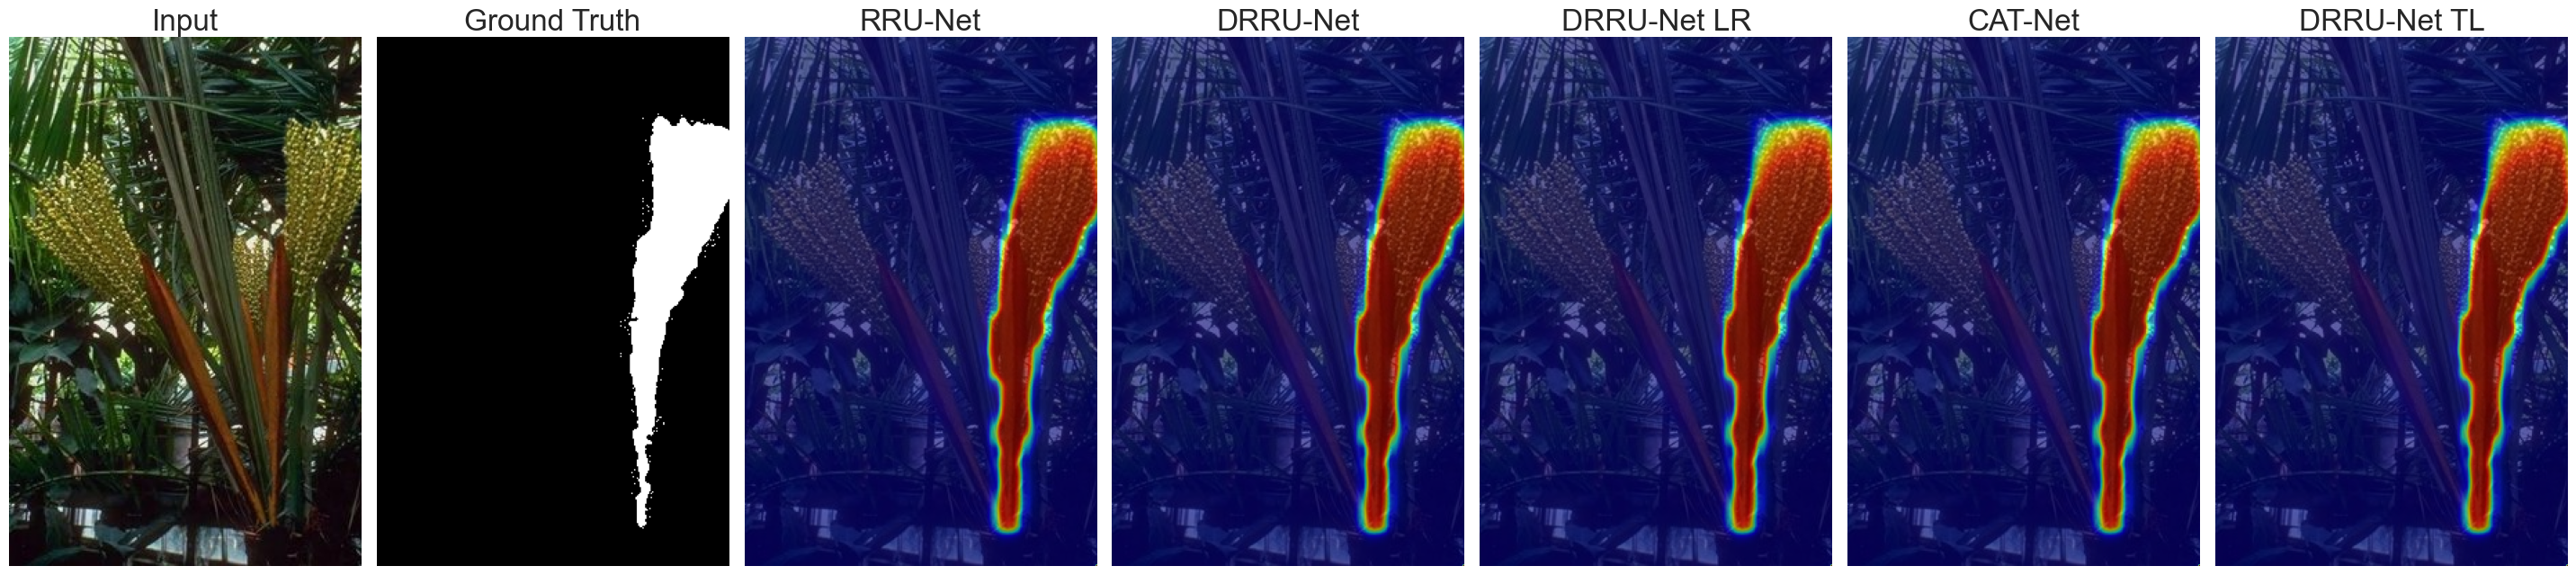

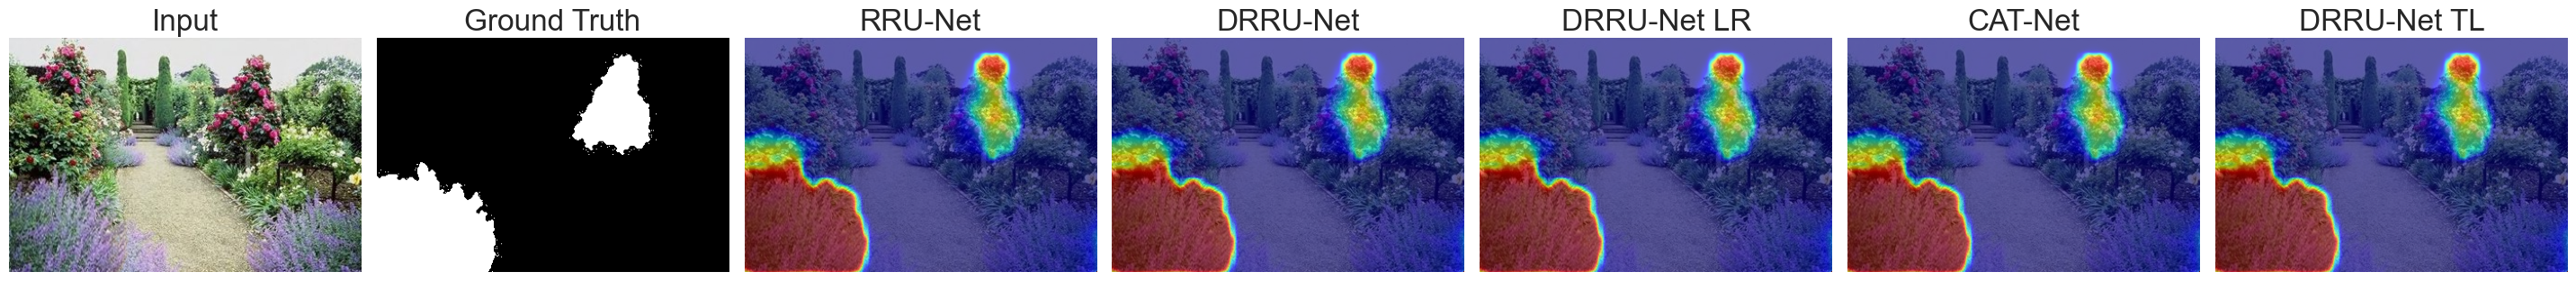

In [91]:
nums = np.random.randint(3059,size=5)
print(list(nums))
nums = [ 753,1243,]
models = [model,model,model,model,model]
names = ['RRU-Net','DRRU-Net','DRRU-Net LR','CAT-Net','DRRU-Net TL']

a = plot_fig(models,names,2,True,*nums,axis=1)


In [78]:

def test_dice(dt):
    # args = parse_args()
    # Instead of using argparse, force these args:
    DT = dt
    DIR_IMGS = [r"F:\datasets\Defacto_splicing\splicing_3_img\img_jpg",
            r"F:\datasets\defacto_copy_move\copymove_img\img_jpg",
            r"F:\datasets\CASIA2.0\Tp_jpg"]
    DIR_IMG = DIR_IMGS[DT]
    DIR_MASKS = [r"F:\datasets\Defacto_splicing\splicing_3_annotations\probe_mask",
    r"F:\datasets\defacto_copy_move\copymove_annotations\probe_mask",
    r"F:\datasets\CASIA2.0\Groundtruth_jpg"]
    DIR_MASK = DIR_MASKS[DT]
    ## CHOOSE ##
    args = argparse.Namespace(cfg='../experiments/CAT_full.yaml', opts=['TEST.MODEL_FILE', '../output/splicing_dataset/CAT_full/best.pth.tar', 'TEST.FLIP_TEST', 'False', 'TEST.NUM_SAMPLES', '0'])
    # args = argparse.Namespace(cfg='experiments/CAT_DCT_only.yaml', opts=['TEST.MODEL_FILE', 'output/splicing_dataset/CAT_DCT_only/DCT_only_v2.pth.tar', 'TEST.FLIP_TEST', 'False', 'TEST.NUM_SAMPLES', '0'])
    update_config(config, args)

    # cudnn related setting
    cudnn.benchmark = config.CUDNN.BENCHMARK
    cudnn.deterministic = config.CUDNN.DETERMINISTIC
    cudnn.enabled = config.CUDNN.ENABLED

    ## CHOOSE ##
    if DIR_IMG == DIR_IMGS[2]:
        num = 3000
    else:
        num = 10000
    test_dataset = DefactoDataset(
                DIR_IMG,
                DIR_MASK,
                num,
                512,
                '0',None,
                blocks=('RGB', 'DCTvol', 'qtable'))
    # splicing_dataset(crop_size=None, grid_crop=True, blocks=('RGB', 'DCTvol', 'qtable'), DCT_channels=1, mode='arbitrary', read_from_jpeg=True)  # full model
    # test_dataset = splicing_dataset(crop_size=None, grid_crop=True, blocks=('DCTvol', 'qtable'), DCT_channels=1, mode='arbitrary', read_from_jpeg=True)  # DCT stream

    # print(test_dataset.get_info())

    testloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,  # must be 1 to handle arbitrary input sizes
        shuffle=False,  # must be False to get accurate filename
        num_workers=1,
        pin_memory=False)

    # criterion
    if config.LOSS.USE_OHEM:
        criterion = OhemCrossEntropy(ignore_label=config.TRAIN.IGNORE_LABEL,
                                     thres=config.LOSS.OHEMTHRES,
                                     min_kept=config.LOSS.OHEMKEEP,
                                     weight=test_dataset.class_weights).cuda()
    else:
        criterion = CrossEntropy(ignore_label=config.TRAIN.IGNORE_LABEL).cuda()

    model = eval('models.' + config.MODEL.NAME +
                 '.get_seg_model')(config)
    if config.TEST.MODEL_FILE:
        model_state_file = config.TEST.MODEL_FILE
    else:
        raise ValueError("Model file is not specified.")
    print('=> loading model from {}'.format(model_state_file))
    model = FullModel(model, criterion)
    checkpoint = torch.load(model_state_file)
    model.model.load_state_dict(checkpoint['state_dict'])
    print("Epoch: {}".format(checkpoint['epoch']))
    gpus = list(config.GPUS)
    model = nn.DataParallel(model, device_ids=gpus).cuda()

    dataset_paths['SAVE_PRED'].mkdir(parents=True, exist_ok=True)

    test_dice = 0.0
    acc_count = 0 # only tamp

    with torch.no_grad():
        model.eval()
        for index, (image, label, qtable) in enumerate(tqdm(testloader)):
            size = label.size()
            image = image.cuda()
            label = label.long().cuda()
            
            _, pred = model(image, label, qtable)
            pred = F.upsample(input=pred, size=(
                        size[-2], size[-1]), mode='bilinear')
            pred = torch.squeeze(pred, 0)
            pred = F.softmax(pred, dim=0)[1]
            # pred = pred.cpu().numpy()

            # filename
            # filename = os.path.splitext(get_next_filename(index))[0] + ".png"
            d = dice_coeff_loss(pred.float(),(label > 0.5).float()) 
            test_dice += d
            pred = pred.detach().cpu().numpy()

            acc_count+= int(True in (pred>0.5))

    test_dice = test_dice / index
    acc_count = acc_count/index
    print("dice : ",test_dice)
    print('accuracy : ',acc_count)
    return test_dice ,acc_count   


In [41]:
dice, acc = test_dice(2) # casia 19m 25s

=> loading model from ../output/splicing_dataset/CAT_full/best.pth.tar
Epoch: 13


100%|██████████| 3000/3000 [12:51<00:00,  3.89it/s]

dice :  tensor(0.1066, device='cuda:0')
accuracy :  0.9976658886295432


In [42]:
dice2, acc2 = test_dice(0) # sp 58m 2s

=> loading model from ../output/splicing_dataset/CAT_full/best.pth.tar
Epoch: 13


100%|██████████| 10000/10000 [43:15<00:00,  3.85it/s]

dice :  tensor(0.3744, device='cuda:0')
accuracy :  0.9832983298329833


In [43]:
dice, acc = test_dice(1) # cm

=> loading model from ../output/splicing_dataset/CAT_full/best.pth.tar
Epoch: 13


100%|██████████| 10000/10000 [41:57<00:00,  3.97it/s]

dice :  tensor(0.3293, device='cuda:0')
accuracy :  0.9795979597959796


In [ ]:
# casia 

# 499 753 1243 1856
# cm
# 3001 7241
# sp
# 1122 5387

# fig2
# cat net drru drru lr
# axis = 0 
# 10 19 48

# fig1
# rru drru drru tl
# axis = 0
# ca 977
# cm 137


In [157]:
# images_path
import shutil

def load_path(dt,*indexes):
    dst_folder = r"C:\Users\zxcas\Desktop\figures\images"

    for i in indexes:
        dataset = DefactoDataset(DIR_IMGS[dt],DIR_MASKS[dt],10000,512,"any",blocks=("RGB",))
        img,_,_ = dataset.__getitem__(i)
        a= dataset.df.iloc[i]
        print(a['image_path'])
        print(a['mask_path'])
        dst_dt,img_file = a['image_path'].split('\\')[2],a['image_path'].split('\\')[-1]
        mask_file = "mask_"+a['mask_path'].split('\\')[-1]
        os.makedirs(os.path.join(dst_folder,dst_dt),exist_ok=True)
        shutil.copy(a['image_path'],os.path.join(dst_folder,dst_dt,img_file))
        shutil.copy(a['mask_path'],os.path.join(dst_folder,dst_dt,mask_file))
        

load_path(1,3001,7241,137)

F:\datasets\defacto_copy_move\copymove_img\img_jpg\0_000000278226.jpg
F:\datasets\defacto_copy_move\copymove_annotations\probe_mask\0_000000278226.jpg
F:\datasets\defacto_copy_move\copymove_img\img_jpg\15_000000402228.jpg
F:\datasets\defacto_copy_move\copymove_annotations\probe_mask\15_000000402228.jpg
F:\datasets\defacto_copy_move\copymove_img\img_jpg\0_000000013140.jpg
F:\datasets\defacto_copy_move\copymove_annotations\probe_mask\0_000000013140.jpg


In [86]:
def validate(testloader, model):
    """
    Dice Coeff, Pixel Acc, f1 
    """
    model.eval()
    model.cuda()
    confusion_matrix = np.zeros(
        (2, 2))

    test_dice = 0.0
    px_acc = 0.0
    px_f1 = 0.0

    with torch.no_grad():
        for i, (image, label, qtable) in enumerate(tqdm(testloader),1):
            size = label.size()
            image = image.cuda()
            label = label.long().cuda()
            
            losses, pred = model(image, label, qtable)
            pred = F.upsample(input=pred, size=(
                        size[-2], size[-1]), mode='bilinear')
            
            current_confusion_matrix = get_confusion_matrix(
                label,
                pred,
                size,
                2,
                -1)
            confusion_matrix += current_confusion_matrix
            pred = torch.squeeze(pred, 0)
            pred = F.softmax(pred, dim=0)[1]
            label = label.squeeze(0)

            dice_coef = dice_coeff_loss(pred.float(),label.float()) 
            test_dice += dice_coef
            # mIoU
            pos = current_confusion_matrix.sum(1)  # ground truth label count
            res = current_confusion_matrix.sum(0)  # prediction count
            tp = np.diag(current_confusion_matrix)  # Intersection part TP, TN
           
            TN = current_confusion_matrix[0, 0]
            FN = current_confusion_matrix[1, 0]
            FP = current_confusion_matrix[0, 1]
            TP = current_confusion_matrix[1, 1]
            b = 1e-7
            #p_mIoU = 0.5 * (FN / np.maximum(1.0, FN + TP + TN)) + 0.5 * (FP / np.maximum(1.0, FP + TP + TN))
            p_acc = (TP + TN ) / np.maximum(1.0,TP+FN+FP+TN) 
            p_rec = TP / np.maximum(1.0,TP+FN) 
            p_pre = TP / np.maximum(1.0,TP+FP) 
            p_f1 = 2*(p_rec*p_pre) / np.maximum(1.0,p_rec + p_pre)   
            px_acc += p_acc
            px_f1 += p_f1
    
    test_dice = test_dice / i
    px_acc = px_acc / i
    px_f1 = px_f1 / i     
    print( test_dice, px_acc, px_f1 ,confusion_matrix )
    return test_dice, px_acc, px_f1 ,confusion_matrix


def get_dt_and_model(dt):
    DT = dt
    DIR_IMGS = [r"F:\datasets\Defacto_splicing\splicing_3_img\img_jpg",
            r"F:\datasets\defacto_copy_move\copymove_img\img_jpg",
            r"F:\datasets\CASIA2.0\Tp_jpg"]
    DIR_IMG = DIR_IMGS[DT]
    DIR_MASKS = [r"F:\datasets\Defacto_splicing\splicing_3_annotations\probe_mask",
    r"F:\datasets\defacto_copy_move\copymove_annotations\probe_mask",
    r"F:\datasets\CASIA2.0\Groundtruth_jpg"]
    DIR_MASK = DIR_MASKS[DT]
    ## CHOOSE ##
    args = argparse.Namespace(cfg='../experiments/CAT_full.yaml', opts=['TEST.MODEL_FILE', '../output/splicing_dataset/CAT_full/best.pth.tar', 'TEST.FLIP_TEST', 'False', 'TEST.NUM_SAMPLES', '0'])
    # args = argparse.Namespace(cfg='experiments/CAT_DCT_only.yaml', opts=['TEST.MODEL_FILE', 'output/splicing_dataset/CAT_DCT_only/DCT_only_v2.pth.tar', 'TEST.FLIP_TEST', 'False', 'TEST.NUM_SAMPLES', '0'])
    update_config(config, args)

    # cudnn related setting
    cudnn.benchmark = config.CUDNN.BENCHMARK
    cudnn.deterministic = config.CUDNN.DETERMINISTIC
    cudnn.enabled = config.CUDNN.ENABLED

    ## CHOOSE ##
    if dt == 2:
        num = 3000
    else:
        num = 10000
    test_dataset = DefactoDataset(
                DIR_IMG,
                DIR_MASK,
                num,
                512,
                'tra0in',None,
                blocks=('RGB', 'DCTvol', 'qtable'))
    print(DIR_IMG)
    # splicing_dataset(crop_size=None, grid_crop=True, blocks=('RGB', 'DCTvol', 'qtable'), DCT_channels=1, mode='arbitrary', read_from_jpeg=True)  # full model
    # test_dataset = splicing_dataset(crop_size=None, grid_crop=True, blocks=('DCTvol', 'qtable'), DCT_channels=1, mode='arbitrary', read_from_jpeg=True)  # DCT stream

    # print(test_dataset.get_info())

    testloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,  # must be 1 to handle arbitrary input sizes
        shuffle=False,  # must be False to get accurate filename
        num_workers=1,
        pin_memory=False)
    model = eval('models.' + config.MODEL.NAME +
                    '.get_seg_model')(config)
    if config.TEST.MODEL_FILE:
        model_state_file = config.TEST.MODEL_FILE
    else:
        raise ValueError("Model file is not specified.")
    print('=> loading model from {}'.format(model_state_file))
    criterion = CrossEntropy(ignore_label=config.TRAIN.IGNORE_LABEL).cuda()
    model = FullModel(model, criterion)
    checkpoint = torch.load(model_state_file)
    model.model.load_state_dict(checkpoint['state_dict'])
    print("Epoch: {}".format(checkpoint['epoch']))
    gpus = list(config.GPUS)
    model = nn.DataParallel(model, device_ids=gpus).cuda()
    
    return testloader,model
    

In [ ]:
testloader,model = get_dt_and_model(0) # j test
validate(testloader,model)

In [81]:
testloader,model = get_dt_and_model(0)
validate(testloader,model)

F:\datasets\Defacto_splicing\splicing_3_img\img_jpg
=> loading model from ../output/splicing_dataset/CAT_full/best.pth.tar
Epoch: 13


  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\zxcas\anaconda3\envs\style\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
c:\Users\zxcas\anaconda3\envs\style\lib\site-packages\torch\nn\functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 10000/10000 [1:04:22<00:00,  2.59it/s]

tensor(0.8029, device='cuda:0') 0.9975697611930165 0.8029224018698549 [[2.2108028e+09 2.1190460e+06]
 [3.3139420e+06 4.6457796e+07]]


(tensor(0.8029, device='cuda:0'),
 0.9975697611930165,
 0.8029224018698549,
 array([[2.2108028e+09, 2.1190460e+06],
        [3.3139420e+06, 4.6457796e+07]]))

In [82]:
testloader,model = get_dt_and_model(1)
validate(testloader,model)

F:\datasets\defacto_copy_move\copymove_img\img_jpg
=> loading model from ../output/splicing_dataset/CAT_full/best.pth.tar
Epoch: 13


100%|██████████| 10000/10000 [46:51<00:00,  3.56it/s]

tensor(0.6586, device='cuda:0') 0.9912977421567867 0.6575153913782009 [[2.14594798e+09 1.29026420e+07]
 [5.77206500e+06 6.82994040e+07]]


(tensor(0.6586, device='cuda:0'),
 0.9912977421567867,
 0.6575153913782009,
 array([[2.14594798e+09, 1.29026420e+07],
        [5.77206500e+06, 6.82994040e+07]]))

In [85]:
testloader,model = get_dt_and_model(2)
validate(testloader,model)

F:\datasets\CASIA2.0\Tp_jpg
=> loading model from ../output/splicing_dataset/CAT_full/best.pth.tar
Epoch: 13


  0%|          | 0/3000 [00:00<?, ?it/s]c:\Users\zxcas\anaconda3\envs\style\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
c:\Users\zxcas\anaconda3\envs\style\lib\site-packages\torch\nn\functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 3000/3000 [13:23<00:00,  3.73it/s]

tensor(0.5885, device='cuda:0') 0.8321011316696414 0.5863489817994075 [[2.91973587e+08 9.90498690e+07]
 [4.23992700e+06 2.39288940e+07]]


(tensor(0.5885, device='cuda:0'),
 0.8321011316696414,
 0.5863489817994075,
 array([[2.91973587e+08, 9.90498690e+07],
        [4.23992700e+06, 2.39288940e+07]]))

In [ ]:
qtable = np.array([[ 3.,  2.,  2.,  3.,  5.,  8., 10., 12.],
       [ 2.,  2.,  3.,  4.,  5., 12., 12., 11.],
       [ 3.,  3.,  3.,  5.,  8., 11., 14., 11.],
       [ 3.,  3.,  4.,  6., 10., 17., 16., 12.],
       [ 4.,  4.,  7., 11., 14., 22., 21., 15.],
       [ 5.,  7., 11., 13., 16., 21., 23., 18.],
       [10., 13., 16., 17., 21., 24., 24., 20.],
       [14., 18., 19., 20., 22., 20., 21., 20.]])
from torchsummary import summary
summary(model.eval(),input_size=(3,512,512))

In [23]:
import torchsummary as toss
import PIL.Image as Image
import numpy as np

sample = Image.open('../input/example.jpg')
sample = np.array(sample)
# print(sample.shape)
# print(crop_size)
# print(model)
model.named_modules().__next__()

('',
 FullModel(
   (model): DataParallel(
     (module): CAT_Net(
       (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (layer1): Sequential(
         (0): Bottleneck(
           (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
           (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
           (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [24]:
[3, ] + [64, ] * (17 - 1)

[3, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]

In [ ]:

# optimizer
logger.info(f"# params with requires_grad = {len([c for c in model.parameters() if c.requires_grad])}, "
            f"# params freezed = {len([c for c in model.parameters() if not c.requires_grad])}")
if config.TRAIN.OPTIMIZER == 'sgd':
    optimizer = torch.optim.SGD([{'params':
                                        filter(lambda p: p.requires_grad,
                                                model.parameters()),
                                    'lr': config.TRAIN.LR}],
                                lr=config.TRAIN.LR,
                                momentum=config.TRAIN.MOMENTUM,
                                weight_decay=config.TRAIN.WD,
                                nesterov=config.TRAIN.NESTEROV,
                                )
else:
    raise ValueError('Only Support SGD optimizer')

epoch_iters = np.int(train_dataset.__len__() /
                        config.TRAIN.BATCH_SIZE_PER_GPU / len(gpus))
best_p_mIoU = 0
last_epoch = 0
if config.TRAIN.RESUME:
    model_state_file = os.path.join(final_output_dir,
                                    'checkpoint.pth.tar')
    if os.path.isfile(model_state_file):
        checkpoint = torch.load(model_state_file,
                                map_location=lambda storage, loc: storage)
        best_p_mIoU = checkpoint['best_p_mIoU']
        last_epoch = checkpoint['epoch']
        model.model.module.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        logger.info("=> loaded checkpoint (epoch {})"
                    .format(checkpoint['epoch']))
    else:
        logger.info("No previous checkpoint.")

start = timeit.default_timer()
end_epoch = config.TRAIN.END_EPOCH + config.TRAIN.EXTRA_EPOCH
num_iters = config.TRAIN.END_EPOCH * epoch_iters
extra_iters = config.TRAIN.EXTRA_EPOCH * epoch_iters

for epoch in range(last_epoch, end_epoch):
    # train
    train_dataset.shuffle()  # for class-balanced sampling
    train(config, epoch, config.TRAIN.END_EPOCH,
            epoch_iters, config.TRAIN.LR, num_iters,
            trainloader, optimizer, model, writer_dict, final_output_dir)

    torch.cuda.empty_cache()
    gc.collect()
    time.sleep(3.0)

    # Valid
    if epoch % 10 == 0 or (epoch >= 80 and epoch % 5 == 0) or epoch >= 120:
        print("Start Validating..")
        writer_dict['valid_global_steps'] = epoch
        valid_loss, mean_IoU, avg_mIoU, avg_p_mIoU, IoU_array, pixel_acc, mean_acc, confusion_matrix = \
            validate(config, validloader, model, writer_dict, "valid")

        torch.cuda.empty_cache()
        gc.collect()
        time.sleep(3.0)

        if avg_p_mIoU > best_p_mIoU:
            best_p_mIoU = avg_p_mIoU
            torch.save({
                'epoch': epoch + 1,
                'best_p_mIoU': best_p_mIoU,
                'state_dict': model.model.module.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, os.path.join(final_output_dir, 'best.pth.tar'))
            logger.info("best.pth.tar updated.")

        msg = '(Valid) Loss: {:.3f}, MeanIU: {: 4.4f}, Best_p_mIoU: {: 4.4f}, avg_mIoU: {: 4.4f}, avg_p_mIoU: {: 4.4f}, Pixel_Acc: {: 4.4f}, Mean_Acc: {: 4.4f}'.format(
            valid_loss, mean_IoU, best_p_mIoU, avg_mIoU, avg_p_mIoU, pixel_acc, mean_acc)
        logging.info(msg)
        logging.info(IoU_array)
        logging.info("confusion_matrix:")
        logging.info(confusion_matrix)

    else:
        logging.info("Skip validation.")

    logger.info('=> saving checkpoint to {}'.format(
        os.path.join(final_output_dir, 'checkpoint.pth.tar')))
    torch.save({
        'epoch': epoch + 1,
        'best_p_mIoU': best_p_mIoU,
        'state_dict': model.model.module.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, os.path.join(final_output_dir, 'checkpoint.pth.tar'))



